# Experiment 4 – Sampling and hidden layer size ablation
Generate samples from the RBM and compare different hidden sizes.

In [5]:

import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

from rbm_utils import (
    load_digits_data,
    load_model,
    save_model,
    rbm_cd1_train,
    rbm_gibbs_step,
    rbm_reconstruct,
    hamming_error,
)

np.random.seed(3)


In [6]:

target_size = (14, 14)
nv = target_size[0] * target_size[1]
X_train, X_test, target_size = load_digits_data(
    target_size=target_size, threshold=0.5, test_size=0.2, seed=1
)

model_path = Path("models/rbm_digits_50.npz")
if model_path.exists():
    params_base, target_size = load_model(str(model_path))
    print("Loaded base model for sampling.")
else:
    params_base, _, _ = rbm_cd1_train(
        X_train,
        X_test,
        nv=nv,
        nh=50,
        epochs=30,
        batch_size=100,
        lr=0.1,
        weight_decay=1e-4,
        seed=0,
    )
    save_model(params_base, target_size, str(model_path))
    print("Trained and saved base model for sampling.")


Loaded base model for sampling.


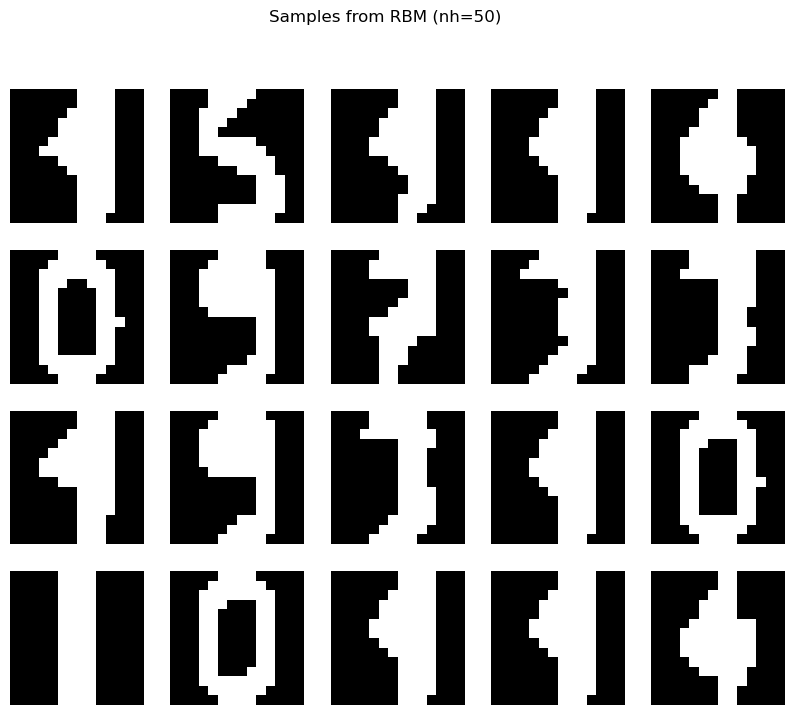

In [7]:

# Part A: sampling from the trained RBM
num_samples = 20
gibbs_steps = 500
samples = []
for _ in range(num_samples):
    v = (np.random.rand(1, nv) < 0.5).astype(np.float32)
    for _ in range(gibbs_steps):
        v = rbm_gibbs_step(v, params_base.W, params_base.b, params_base.c)
    samples.append(v.squeeze())
samples = np.array(samples)

rows = int(np.ceil(num_samples / 5))
fig, axes = plt.subplots(rows, 5, figsize=(10, 2 * rows))
for idx, ax in enumerate(axes.flat):
    if idx < num_samples:
        ax.imshow(samples[idx].reshape(target_size), cmap="gray")
    ax.axis("off")
plt.suptitle("Samples from RBM (nh=50)")
plt.show()


In [8]:

# Part B: compare hidden layer sizes
hidden_sizes = [20, 50, 100]
train_curves = {}
test_curves = {}
final_errors = {}
trained_params = {}

for nh in hidden_sizes:
    print(f"\nTraining RBM with {nh} hidden units...")
    params_h, train_errs, test_errs = rbm_cd1_train(
        X_train,
        X_test,
        nv=nv,
        nh=nh,
        epochs=30,
        batch_size=100,
        lr=0.1,
        weight_decay=1e-4,
        seed=nh,
    )
    train_curves[nh] = train_errs
    test_curves[nh] = test_errs
    trained_params[nh] = params_h

    recon = rbm_reconstruct(X_test, params_h.W, params_h.b, params_h.c)
    final_errors[nh] = hamming_error(X_test, recon)



Training RBM with 20 hidden units...
Epoch 1/30 - train err 0.2186 - test err 0.2246
Epoch 2/30 - train err 0.2198 - test err 0.2241
Epoch 3/30 - train err 0.2203 - test err 0.2246
Epoch 4/30 - train err 0.2196 - test err 0.2242
Epoch 5/30 - train err 0.2216 - test err 0.2233
Epoch 6/30 - train err 0.2062 - test err 0.2099
Epoch 7/30 - train err 0.1974 - test err 0.2027
Epoch 8/30 - train err 0.1804 - test err 0.1819
Epoch 9/30 - train err 0.1618 - test err 0.1645
Epoch 10/30 - train err 0.1567 - test err 0.1579
Epoch 11/30 - train err 0.1472 - test err 0.1473
Epoch 12/30 - train err 0.1421 - test err 0.1411
Epoch 13/30 - train err 0.1401 - test err 0.1390
Epoch 14/30 - train err 0.1375 - test err 0.1363
Epoch 15/30 - train err 0.1353 - test err 0.1341
Epoch 16/30 - train err 0.1342 - test err 0.1332
Epoch 17/30 - train err 0.1325 - test err 0.1320
Epoch 18/30 - train err 0.1303 - test err 0.1293
Epoch 19/30 - train err 0.1294 - test err 0.1289
Epoch 20/30 - train err 0.1262 - test er

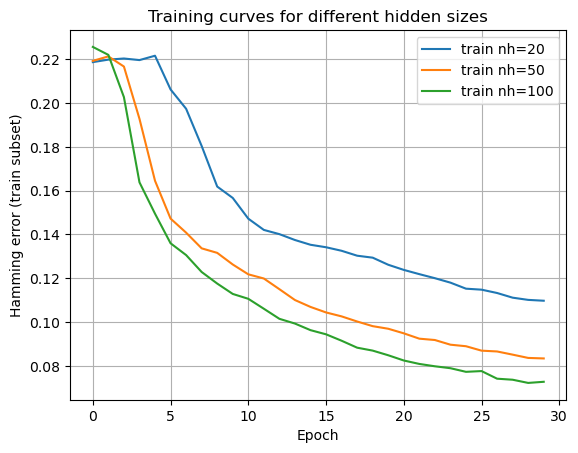

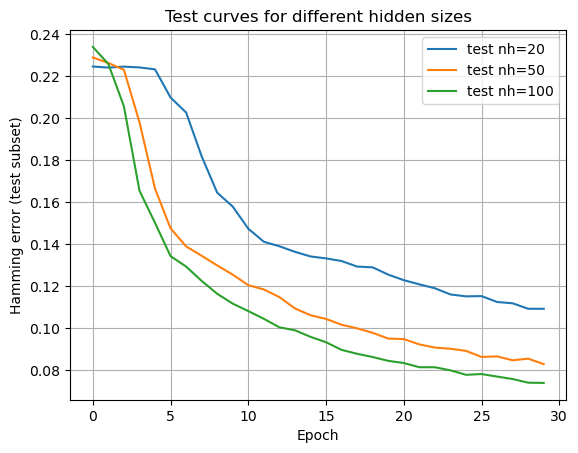

In [9]:

# Plot training curves
for nh, errs in train_curves.items():
    plt.plot(errs, label=f"train nh={nh}")
plt.xlabel("Epoch")
plt.ylabel("Hamming error (train subset)")
plt.title("Training curves for different hidden sizes")
plt.legend()
plt.grid(True)
plt.show()

# Plot test curves
for nh, errs in test_curves.items():
    plt.plot(errs, label=f"test nh={nh}")
plt.xlabel("Epoch")
plt.ylabel("Hamming error (test subset)")
plt.title("Test curves for different hidden sizes")
plt.legend()
plt.grid(True)
plt.show()


In [10]:

print("Final test errors after training:\n")
for nh in hidden_sizes:
    print(f" nh={nh}: test error {final_errors[nh]:.4f}")


Final test errors after training:

 nh=20: test error 0.1090
 nh=50: test error 0.0832
 nh=100: test error 0.0739


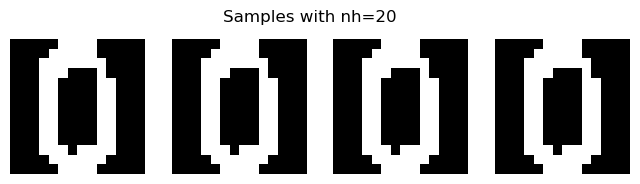

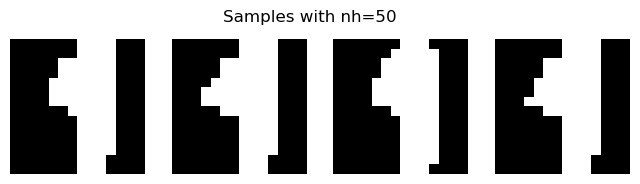

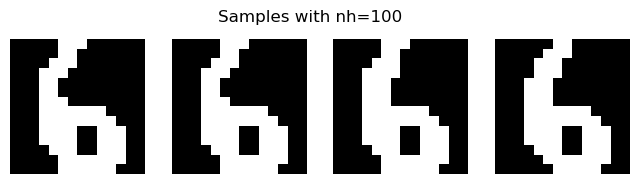

In [11]:

# Small sample grids for each model
for nh, params_h in trained_params.items():
    num_show = 6
    v = (np.random.rand(1, nv) < 0.5).astype(np.float32)
    samples = []
    for t in range(200):
        v = rbm_gibbs_step(v, params_h.W, params_h.b, params_h.c)
        if t > 120 and (t - 120) % 16 == 0 and len(samples) < num_show:
            samples.append(v.squeeze())
    if not samples:
        continue
    samples = np.array(samples)
    fig, axes = plt.subplots(1, len(samples), figsize=(len(samples) * 2, 2))
    for idx, ax in enumerate(np.atleast_1d(axes)):
        ax.imshow(samples[idx].reshape(target_size), cmap="gray")
        ax.axis("off")
    plt.suptitle(f"Samples with nh={nh}")
    plt.show()
